In [0]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from sklearn.preprocessing import MinMaxScaler

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
articles_df = pd.read_csv('/content/drive/My Drive/Colab/Recommender/Article_Lists/articles_indian_exp_new.csv')


In [0]:
for i in range(0,len(articles_df)):
  a=articles_df['article_id'][i]
  a=int(a[6:])
  articles_df['article_id'][i]=a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
articles_df.tail()

,Unnamed: 0,article_id,headline,desc,date,url,articles,article_type,article_length
19995,19995,5,"DNA sampling in rape cases: MP showcauses 1,25...","On July 18, 2019, the government submitted a r...","August 11, 2019 4:27:34 am",https://indianexpress.com/article/india/dna-sa...,The Madhya Pradesh government has served showc...,mid,1763
19996,19996,4,Sonia to Rahul to Sonia: Congress takes step b...,Sonia was appointed interim president until or...,"August 11, 2019 9:44:49 am",https://indianexpress.com/article/india/sonia-...,Three months after Rahul Gandhi quit as party ...,long,5724
19997,19997,3,Pay cash relief to flood-hit people: Congress ...,"Sachin Sawant, general secretary and spokesper...","August 11, 2019 9:08:30 am",https://indianexpress.com/article/india/pay-ca...,SLAMMING THE state for its decision to deposit...,mid,1242
19998,19998,2,Maharashtra floods: Govt asks oil industry to ...,In another letter to the Ministry of Home Affa...,"August 11, 2019 4:09:25 am",https://indianexpress.com/article/india/mahara...,THE state government on Saturday asked the oil...,mid,1444
19999,19999,1,Jammu and Kashmir: BJP wants some curbs to be ...,Senior BJP leader Nirmal Singh told The Sunday...,"August 11, 2019 3:52:31 pm",https://indianexpress.com/article/india/jammu-...,Less than a week after the abrogation of Artic...,long,3452


In [0]:
interactions_df = pd.read_csv('/content/drive/My Drive/Colab/Recommender/clickstream_final.csv')

In [0]:
l1=interactions_df['article_id']
l2=interactions_df['user_id']
l3=[]
l4=[]

In [0]:
for i in range(0,len(interactions_df)):
  a=l1[i]
  a=int(a[6:])
  l3.append(a)
  b=l2[i]
  b=int(b[4:])
  l4.append(b)

In [0]:
interactions_df['article_id']=l3
interactions_df['user_id']=l4

In [0]:
interactions_df.head()

,user_id,session_id,article_id,click,click_value,article_length,timeonpage,read_percentage,updated_percentage,interest
0,12049,session-7047,10295,0,not_view,2615,0.000000,0.000000,0.000000,0.000000
1,12049,session-7047,15353,0,not_view,1637,0.000000,0.000000,0.000000,0.000000
2,12049,session-7047,751,1,view,1098,20.119364,45.809117,50.809117,0.508091
3,12049,session-7047,7493,1,view,3158,129.134206,102.227839,100.000000,1.000000
4,12049,session-7047,2999,0,not_view,3298,0.000000,0.000000,0.000000,0.000000


In [0]:
def get_items_interacted(user_id, interactions_df):
    interacted_items = interactions_df.loc[user_id]['article_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [0]:
get_items_interacted(1075,interactions_df)

{9346}

In [0]:
interactions_train_df, interactions_test_df = train_test_split(interactions_df, 
                                   stratify=interactions_df['user_id'],
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 223621
# interactions on Test set: 55906


In [0]:
interactions_df = interactions_df.set_index('user_id')
interactions_train_df = interactions_train_df.set_index('user_id')
interactions_test_df = interactions_test_df.set_index('user_id')




##Content based Filtering

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stopwords_list = stopwords.words('english') 

vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['article_id'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['headline'] + "" + articles_df['articles'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<20000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2973344 stored elements in Compressed Sparse Row format>

In [0]:

def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_df):
    interactions_person_df = interactions_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['article_id'])
    
    user_item_strengths = np.array(interactions_person_df['interest']).reshape(-1,1)
    if (np.sum(user_item_strengths)==0):
      user_item_strengths_weighted_avg=0
    else:
      user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    return user_item_strengths_weighted_avg

def build_users_profiles(): 
    interactions_indexed_df = interactions_df[interactions_df['article_id'] \
                                                   .isin(articles_df['article_id'])]
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [0]:
user_profiles = build_users_profiles()
len(user_profiles)

14000

In [0]:
myprofile = user_profiles[4621]
print(myprofile[0].flatten().tolist()[0])
rev = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        myprofile[0].flatten().tolist()[0]), key=lambda x: x[1]),
             columns=['token', 'relevance']).sort_values('relevance')
rev.tail(10)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023762658499961106, 0.028818555766888902, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02831108400152269, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005951853667783267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006407690081894617, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009622445744140657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

,token,relevance
4990,tmc,0.088936
4991,kolkata,0.097315
4992,idol,0.097854
4993,congress,0.099609
4994,police,0.106238
4995,woman,0.112096
4996,policemen,0.121565
4997,nrc,0.146956
4998,trinamool,0.210515
4999,trinamool congress,0.215602


In [0]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['article_id', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'article_id', 
                                                          right_on = 'article_id')[['recStrength', 'article_id', 'headline', 'url']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

In [0]:
cbrm = content_based_recommender_model.recommend_items(4621,topn=10, verbose=True)

##Collaborative based Filtering

In [0]:
users_items_pivot_matrix_df = interactions_train_df.pivot_table(index='user_id', columns='article_id', values='updated_percentage').fillna(0)

users_items_pivot_matrix_df.shape

(14000, 19997)

In [0]:
users_items_pivot_matrix_df[1].value_counts()

0.000000      13993
100.000000        2
35.318276         1
31.140241         1
31.476557         1
20.354689         1
25.611870         1
Name: 1, dtype: int64

In [0]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix_df)

In [0]:
users_items_pivot_sparse_matrix.max()

100.0

In [0]:
NUMBER_OF_FACTORS_MF = 150
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [0]:
U.max()

0.8687930627086072

In [0]:
Vt.min()

-0.3323233990457908

In [0]:
sigma = np.diag(sigma)
sigma.shape

(150, 150)

In [0]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings.max()

157.3933252916043

In [0]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [0]:
all_user_predicted_ratings_norm

array([[0.09589311, 0.09585588, 0.09552616, ..., 0.09588736, 0.09594236,
        0.0961508 ],
       [0.09584041, 0.09612774, 0.0957341 , ..., 0.09600385, 0.09596431,
        0.09608139],
       [0.09589857, 0.09603904, 0.09645   , ..., 0.09597301, 0.09603703,
        0.09624473],
       ...,
       [0.09591217, 0.0955583 , 0.0945504 , ..., 0.09606369, 0.09592688,
        0.09537863],
       [0.09597704, 0.09567593, 0.09544634, ..., 0.09619837, 0.09597081,
        0.09577179],
       [0.0957323 , 0.09619447, 0.09517761, ..., 0.09575452, 0.09598229,
        0.09505679]])

In [0]:
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns).transpose()
cf_preds_df.max()

0        0.134472
1        0.116603
2        0.133135
3        0.184175
4        0.120316
           ...   
13995    0.108294
13996    0.111290
13997    0.144943
13998    0.111322
13999    0.128092
Length: 14000, dtype: float64

In [0]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        recommendations_df = sorted_user_predictions[~sorted_user_predictions['article_id'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'article_id', 
                                                          right_on = 'article_id')[['recStrength', 'article_id', 'headline', 'url']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [0]:
colf = cf_recommender_model.recommend_items(user_id=4621,verbose=True)

In [0]:
cf_recommender_model.recommend_items(user_id=4621,verbose=True)

,recStrength,article_id,headline,url
0,0.118899,4970,Kerala state Lottery Today Results announced: ...,https://indianexpress.com/article/india/kerala...
1,0.105708,8723,Citizenship Amendment Bill: SAD backs legislat...,https://indianexpress.com/article/india/citize...
2,0.105072,3279,Pakistan continues ceasefire violation for thi...,https://indianexpress.com/article/india/pakist...
3,0.104713,3247,Gandhian Leelatai Merchant dies,https://indianexpress.com/article/india/gandhi...
4,0.104245,18476,Nirmala Sitharaman Announcements highlights: P...,https://indianexpress.com/article/india/fm-nir...
5,0.104179,13925,"Navy’s MiG 29k aircraft crashes near Goa, pilo...",https://indianexpress.com/article/india/indian...
6,0.103989,18122,"UP: In Jhansi, 300 civil volunteers act as for...",https://indianexpress.com/article/india/up-in-...
7,0.103909,4509,Dantewada: Police say Maoist killed in encount...,https://indianexpress.com/article/india/dantew...
8,0.103850,4404,PMC Bank fraud: Ex-chairman sent to police cus...,https://indianexpress.com/article/india/pmc-ba...
9,0.103466,841,"Justice Sunil Gaur, who handled key cases, ret...",https://indianexpress.com/article/india/justic...


In [0]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, user_id, sample_size, seed=42):
        interacted_items = get_items_interacted(user_id, interactions_df)
        all_items = set(articles_df['article_id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, user_id):
        interacted_values_testset = interactions_test_df.loc[user_id]
        if type(interacted_values_testset['article_id']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset.index)
            
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['article_id'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 
        person_recs_df = model.recommend_items(user_id, 
                                               items_to_ignore=get_items_interacted(user_id, 
                                                                                    interactions_train_df), 
                                               topn=10000000000)
        hits_at_5_count = 0
        hits_at_10_count = 0
        for item_id in person_interacted_items_testset:
            non_interacted_items_sample = self.get_not_interacted_items_sample(item_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            valid_recs_df = person_recs_df[person_recs_df['article_id'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['article_id'].values
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_df.index.unique().values)):
          try:
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
          except:
            pass
        print('%d users processed' % idx)
        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [0]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
13999 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.05101093091376724, 'recall@10': 0.09887833107094378}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
0,0,0,1,0.0,0.0,400
9335,0,0,1,0.0,0.0,340
9324,0,0,1,0.0,0.0,8800
9325,0,0,1,0.0,0.0,10338
9326,0,0,1,0.0,0.0,721
9327,0,0,1,0.0,0.0,12970
9328,0,0,1,0.0,0.0,8976
9329,0,0,1,0.0,0.0,2610
9330,0,0,1,0.0,0.0,12559
9331,0,0,1,0.0,0.0,10078


## Hybrid RecSys

In [0]:
cbrm.sample(n=3).append(colf.sample(n=7)).sample(frac=1).reset_index(drop=True)

,recStrength,article_id,headline,url
0,0.105708,8723,Citizenship Amendment Bill: SAD backs legislat...,https://indianexpress.com/article/india/citize...
1,0.131605,13439,"Firing near CAA protest site in Bihar, 2 detained",https://indianexpress.com/article/india/firing...
2,0.103850,4404,PMC Bank fraud: Ex-chairman sent to police cus...,https://indianexpress.com/article/india/pmc-ba...
3,0.131454,13383,"Kanhaiya’s convoy attacked in Ara, two injured...",https://indianexpress.com/article/india/kanhai...
4,0.103989,18122,"UP: In Jhansi, 300 civil volunteers act as for...",https://indianexpress.com/article/india/up-in-...
5,0.104179,13925,"Navy’s MiG 29k aircraft crashes near Goa, pilo...",https://indianexpress.com/article/india/indian...
6,0.118899,4970,Kerala state Lottery Today Results announced: ...,https://indianexpress.com/article/india/kerala...
7,0.105072,3279,Pakistan continues ceasefire violation for thi...,https://indianexpress.com/article/india/pakist...
8,0.131341,10970,Tamil Nadu cop killed in revenge attack for te...,https://indianexpress.com/article/india/tamil-...
9,0.104713,3247,Gandhian Leelatai Merchant dies,https://indianexpress.com/article/india/gandhi...


## Clustering

In [0]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.sparse import find
import itertools
import numpy.matlib
import random
from gensim import corpora, models, similarities
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

In [0]:
news_articles = pd.read_csv('/content/drive/My Drive/articles_indian_exp_new.csv')

In [0]:
print(news_articles.dtypes)

Unnamed: 0         int64
article_id        object
headline          object
desc              object
date              object
url               object
articles          object
article_type      object
article_length     int64
dtype: object


In [0]:
corpus = [sentence for sentence in news_articles.articles]

In [0]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import string
    

In [0]:
def remove_punctuation(sentence):
    """Remove punctuation , whitespace and covert them in lower"""
    
    sentence = sentence.lower()
    
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    words = sentence.split()

    # remove punctuation from each word

    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in words]

    sentence = " ".join(list(tokens))


    return sentence


In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [0]:
def remove_stopwords(sentence):
  """this function remove the stop words and stem the words""" 
    word_tokens = str(sentence).split()
    
    tokens = [word for word in word_tokens if not word in stop_words] 

    stem = [stemmer.stem(t) for t in tokens ]

    sentence = " ".join(list(stem))
    
    return sentence

In [0]:
corpus_without_punctuation = [(lambda doc:remove_punctuation(doc))(doc) for doc in corpus]

In [0]:
corpus_without_stopwords = [(lambda doc:remove_stopwords(doc))(doc) for doc in corpus_without_punctuation]

In [0]:
refined_vocab = corpus_without_stopwords

In [0]:
print(len(refined_vocab))


20000


Vectorizing the articles using TfidfVectorizer


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df = 0.8, max_features = 400000,
                        min_df = 0.2, stop_words = "english",
                        ngram_range=(1,3))

tfidf_matrix = tfidf.fit_transform(refined_vocab)

In [0]:
print(tfidf_matrix.shape)

(20000, 64)


In [0]:
terms = tfidf.get_feature_names()

In [0]:
print(terms)

['accord', 'act', 'ad', 'alleg', 'area', 'ask', 'bjp', 'case', 'centr', 'chief', 'chief minist', 'claim', 'come', 'congress', 'countri', 'court', 'day', 'delhi', 'district', 'earlier', 'express', 'follow', 'govern', 'home', 'howev', 'includ', 'india', 'indian', 'issu', 'leader', 'like', 'make', 'mani', 'meet', 'member', 'minist', 'month', 'nation', 'new', 'number', 'offic', 'offici', 'order', 'parti', 'peopl', 'person', 'place', 'polic', 'public', 'report', 'rs', 'say', 'senior', 'sever', 'sinc', 'singh', 'state', 'taken', 'time', 'told', 'union', 'use', 'work', 'year']


Calculating the similarity of the tfidf vectors using cosine similarity

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [0]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


In [0]:
K = range(1,10)

In [0]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

In [0]:
distortions = []
for k in K:
  km = KMeans(n_clusters=k)
  %time km.fit(tfidf_matrix)
  distortions.append(km.inertia_)

CPU times: user 6.42 s, sys: 9.99 ms, total: 6.43 s
Wall time: 6.44 s
CPU times: user 47.1 s, sys: 93.9 ms, total: 47.2 s
Wall time: 47.2 s
CPU times: user 1min 16s, sys: 207 ms, total: 1min 16s
Wall time: 1min 16s
CPU times: user 1min, sys: 278 ms, total: 1min
Wall time: 1min
CPU times: user 1min, sys: 354 ms, total: 1min
Wall time: 1min
CPU times: user 57.2 s, sys: 398 ms, total: 57.6 s
Wall time: 57.6 s
CPU times: user 1min 22s, sys: 501 ms, total: 1min 22s
Wall time: 1min 22s
CPU times: user 2min 18s, sys: 480 ms, total: 2min 19s
Wall time: 2min 19s
CPU times: user 2min 6s, sys: 559 ms, total: 2min 6s
Wall time: 2min 6s


In [0]:
d = []
kms = KMeans(n_clusters=6)
kms.fit(tfidf_matrix)
d.append(kms.inertia_)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(tfidf_matrix.todense())
ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
ax[0].set_title('PCA Cluster Plot')

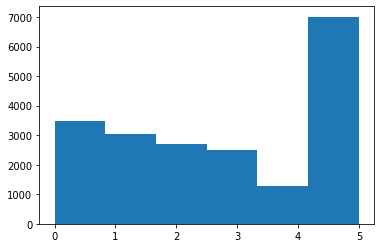

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(kms.labels_, bins=6)
plt.show()


Elbow curve

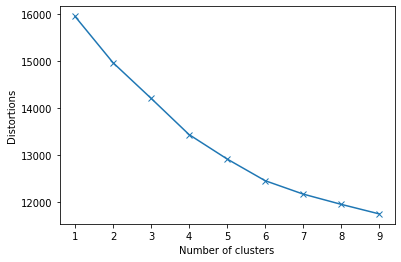

<Figure size 360x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(range(1,10), distortions, marker='x')

plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.figure(figsize=(5, 10))
plt.show()
plt.savefig('Elbow curve 1', dpi=200)

In [0]:
K = range(2,10)
from sklearn.metrics import silhouette_score, silhouette_samples

sil_distortions = []
for k in K:
  cluster = KMeans(n_clusters = k)
  cluster_labels = cluster.fit_predict(tfidf_matrix)
  sil_distortions.append(silhouette_score(tfidf_matrix, cluster_labels, metric = 'euclidean'))
  

Silhouette curve

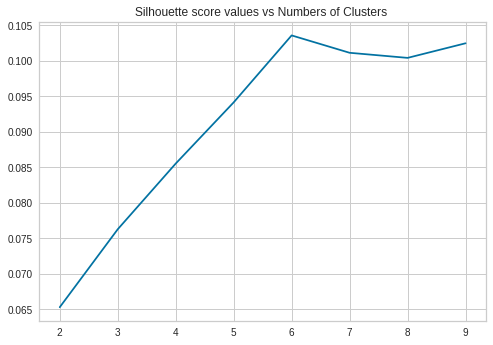

<Figure size 576x396 with 0 Axes>

In [0]:
plt.plot(K, sil_distortions)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
plt.savefig('Silhouette curve', dpi=200)